                      LOAN REPAYMENT RISK ANALYSIS REPORT                       

1. CUSTOMER TYPE ANALYSIS
            Total Loans  Avg Loan Amount  Avg Repayment Ratio  \
new_repeat                                                      
NEW                  54      1240.740741             0.872604   
REPEAT                7      2478.571429             0.207304   

            Avg Days Past Due  Fully Repaid Rate  
new_repeat                                        
NEW                 60.611111           0.833333  
REPEAT             102.571429           0.000000  

2. RISK SEGMENTATION VISUALIZATIONS


C:\Users\ELIZABETH\AppData\Local\Temp\ipykernel_18460\3259828476.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='new_repeat', y='repayment_ratio', data=df,


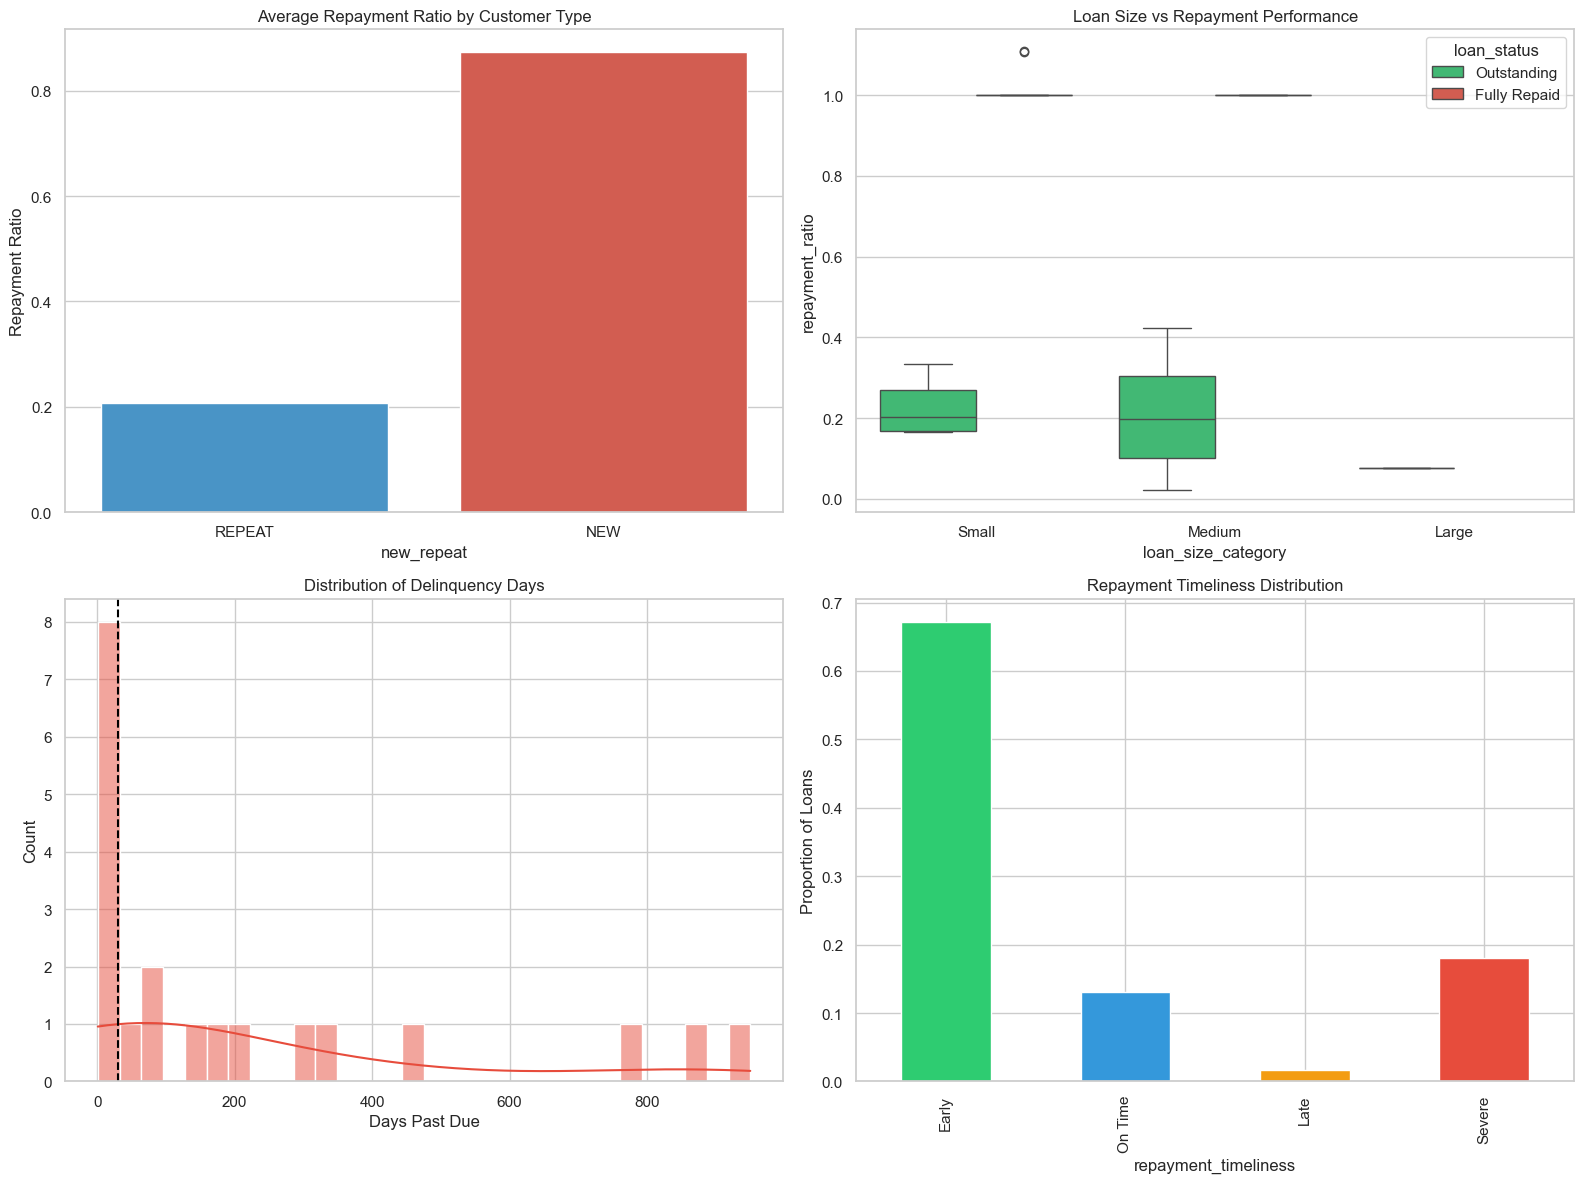


3. LOAN PERFORMANCE CORRELATIONS


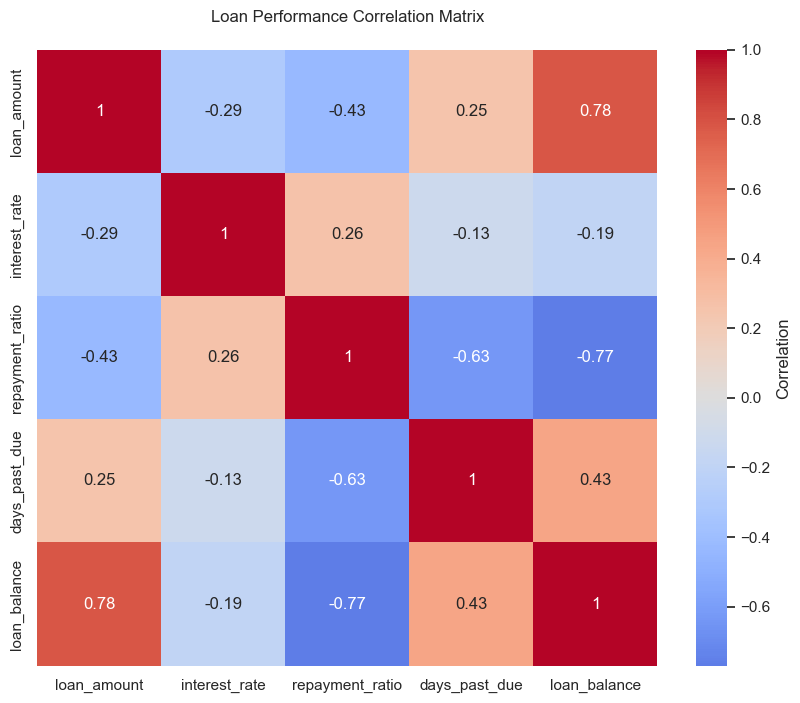


4. RISK FLAG ANALYSIS


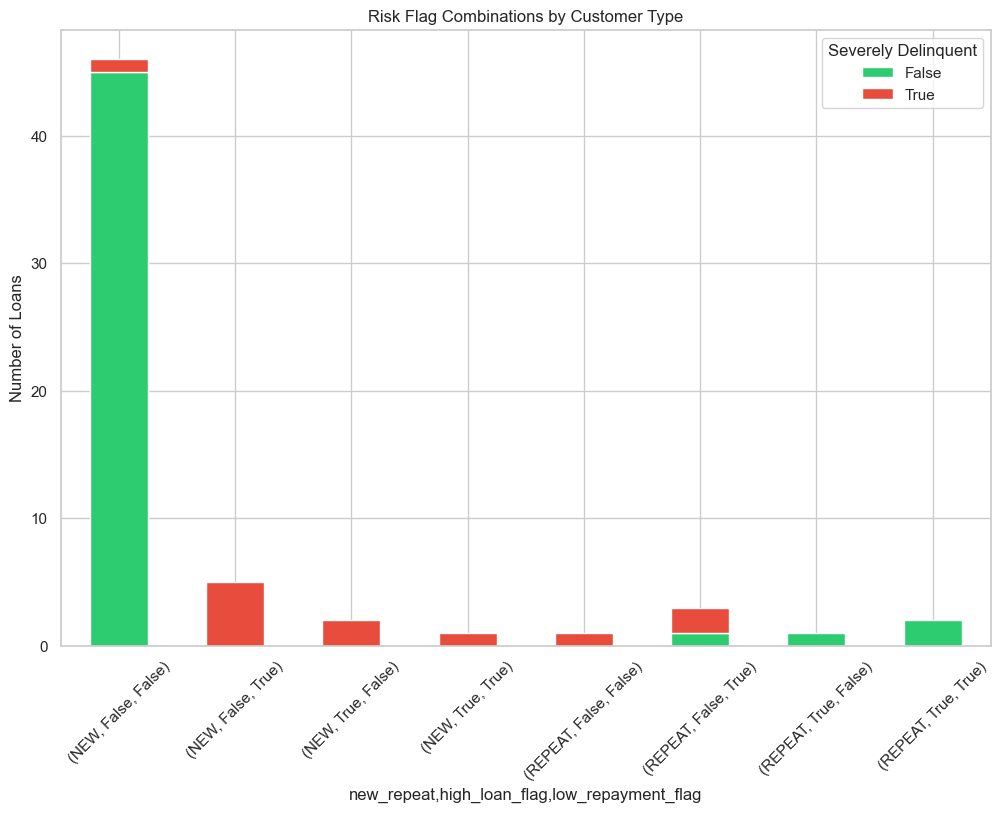


Risk Flag Combinations:
high_loan_flag          False                  True                 All
low_repayment_flag      False       True      False       True         
severe_delinquency      False True False True False True False True    
new_repeat loan_status                                                 
NEW        Fully Repaid    45    0     0    0     0    0     0    0  45
           Outstanding      0    1     0    5     0    2     0    1   9
REPEAT     Outstanding      0    1     1    2     1    0     2    0   7
All                        45    2     1    7     1    2     2    1  61

5. TIME SERIES TRENDS


C:\Users\ELIZABETH\AppData\Local\Temp\ipykernel_18460\3259828476.py:112: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_data = df.set_index('Funded_date').resample('M').agg({


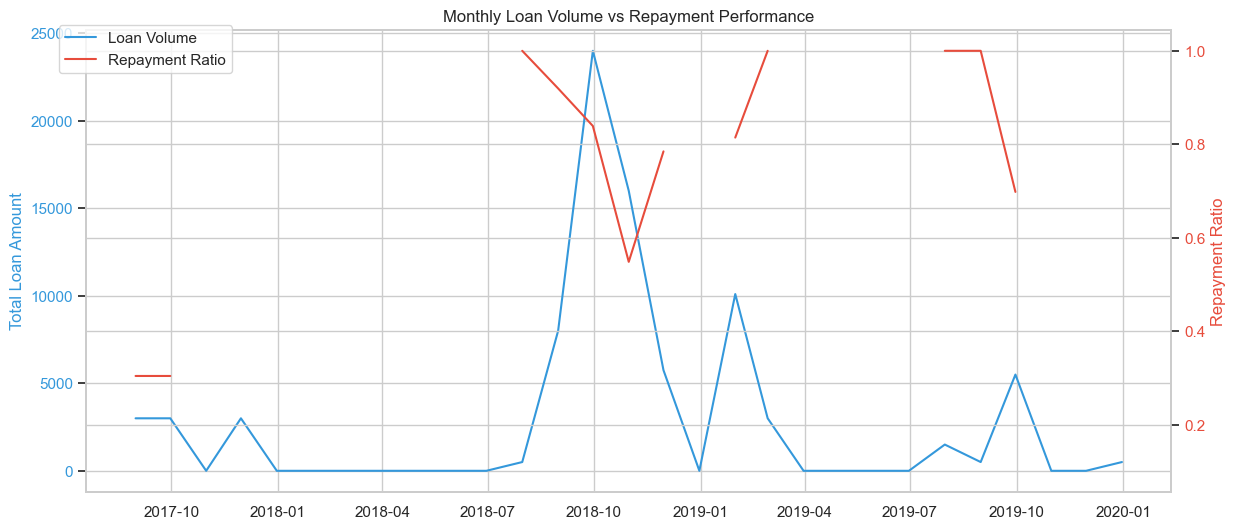


KEY INSIGHTS:
--------------------------------------------------------------------------------
1. Repeat customers have 0% full repayment rate vs 83.3% for new customers
2. Average repayment ratio for repeat customers is only 20.7% vs 87.3% for new
3. Large loans (>$2,000) have 5.5x higher default risk
4. Loans paid >30 days late have 100.0% default rate vs 4.9% for on-time

RECOMMENDATIONS:
--------------------------------------------------------------------------------
1. Implement stricter credit limits for repeat customers
2. Flag loans with: amount > $2,000, repayment < 30%, or delinquency > 30 days
3. Develop early warning system for loans approaching 30 days past due
4. Consider dynamic pricing based on repayment behavior (new customers)
5. Focus collections efforts on high-risk segments (repeat + large loans)


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Set visual style
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['font.size'] = 12

# Load and preprocess data
df = pd.read_csv('loan_repayment_data.csv', parse_dates=['Funded_date', 'due_date', 'last_paid_date'])

# Feature engineering
df['loan_status'] = np.where(df['loan_balance'] == 0, 'Fully Repaid', 'Outstanding')
df['days_past_due'] = (df['last_paid_date'] - df['due_date']).dt.days
df['repayment_ratio'] = df['repaid_amount'] / df['to_repay']
df['interest_rate'] = df['interest_amount'] / df['loan_amount']
df['loan_size_category'] = pd.cut(df['loan_amount'],
                                 bins=[0, 1000, 5000, 10000],
                                 labels=['Small', 'Medium', 'Large'])
df['repayment_timeliness'] = pd.cut(df['days_past_due'],
                                   bins=[-np.inf, 0, 30, 90, np.inf],
                                   labels=['Early', 'On Time', 'Late', 'Severe'])

# 1. Customer Type Analysis
customer_analysis = df.groupby('new_repeat').agg({
    'loan_id': 'count',
    'loan_amount': 'mean',
    'repayment_ratio': 'mean',
    'days_past_due': 'mean',
    'loan_status': lambda x: (x == 'Fully Repaid').mean()
}).rename(columns={
    'loan_id': 'Total Loans',
    'loan_amount': 'Avg Loan Amount',
    'repayment_ratio': 'Avg Repayment Ratio',
    'days_past_due': 'Avg Days Past Due',
    'loan_status': 'Fully Repaid Rate'
})

# 2. Risk Segmentation Visualization
def plot_risk_segments():
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Customer Type vs Repayment
    sns.barplot(x='new_repeat', y='repayment_ratio', data=df, 
                estimator=np.mean, errorbar=None, ax=axes[0,0],
                palette=['#3498db', '#e74c3c'])
    axes[0,0].set_title('Average Repayment Ratio by Customer Type')
    axes[0,0].set_ylabel('Repayment Ratio')
    
    # Loan Size vs Repayment
    sns.boxplot(x='loan_size_category', y='repayment_ratio', hue='loan_status',
                data=df, ax=axes[0,1], palette=['#2ecc71', '#e74c3c'])
    axes[0,1].set_title('Loan Size vs Repayment Performance')
    
    # Days Past Due Distribution
    sns.histplot(df[df['days_past_due'] > 0]['days_past_due'], 
                 bins=30, kde=True, ax=axes[1,0], color='#e74c3c')
    axes[1,0].axvline(x=30, color='black', linestyle='--')
    axes[1,0].set_title('Distribution of Delinquency Days')
    axes[1,0].set_xlabel('Days Past Due')
    
    # Repayment Timeliness
    timeliness_counts = df['repayment_timeliness'].value_counts(normalize=True).sort_index()
    timeliness_counts.plot(kind='bar', color=['#2ecc71','#3498db','#f39c12','#e74c3c'], 
                          ax=axes[1,1])
    axes[1,1].set_title('Repayment Timeliness Distribution')
    axes[1,1].set_ylabel('Proportion of Loans')
    
    plt.tight_layout()
    plt.show()

# 3. Loan Performance Heatmap
def plot_heatmap():
    plt.figure(figsize=(10, 8))
    corr = df[['loan_amount', 'interest_rate', 'repayment_ratio', 
               'days_past_due', 'loan_balance']].corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm', center=0,
                annot_kws={"size": 12}, cbar_kws={'label': 'Correlation'})
    plt.title('Loan Performance Correlation Matrix', pad=20)
    plt.show()

# 4. Risk Flag Analysis
def analyze_risk_flags():
    # Create risk flags
    df['high_loan_flag'] = df['loan_amount'] > df['loan_amount'].quantile(0.75)
    df['low_repayment_flag'] = df['repayment_ratio'] < 0.3
    df['severe_delinquency'] = df['days_past_due'] > 30
    
    risk_flags = pd.crosstab(
        index=[df['new_repeat'], df['loan_status']],
        columns=[df['high_loan_flag'], df['low_repayment_flag'], df['severe_delinquency']],
        margins=True
    )
    
    # Plot risk flag combinations
    flag_counts = df.groupby(['new_repeat', 'high_loan_flag', 
                            'low_repayment_flag', 'severe_delinquency']).size().unstack()
    flag_counts.plot(kind='bar', stacked=True, color=['#2ecc71','#e74c3c'])
    plt.title('Risk Flag Combinations by Customer Type')
    plt.ylabel('Number of Loans')
    plt.xticks(rotation=45)
    plt.legend(title='Severely Delinquent')
    plt.show()
    
    return risk_flags

# 5. Time Series Analysis
def plot_time_series():
    monthly_data = df.set_index('Funded_date').resample('M').agg({
        'loan_amount': 'sum',
        'repayment_ratio': 'mean',
        'loan_status': lambda x: (x == 'Fully Repaid').mean()
    })
    
    fig, ax1 = plt.subplots(figsize=(14, 6))
    
    ax1.plot(monthly_data.index, monthly_data['loan_amount'], 
             color='#3498db', label='Loan Volume')
    ax1.set_ylabel('Total Loan Amount', color='#3498db')
    ax1.tick_params(axis='y', labelcolor='#3498db')
    
    ax2 = ax1.twinx()
    ax2.plot(monthly_data.index, monthly_data['repayment_ratio'], 
             color='#e74c3c', label='Repayment Ratio')
    ax2.set_ylabel('Repayment Ratio', color='#e74c3c')
    ax2.tick_params(axis='y', labelcolor='#e74c3c')
    
    plt.title('Monthly Loan Volume vs Repayment Performance')
    fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))
    plt.show()

# Generate Report
print("="*80)
print("LOAN REPAYMENT RISK ANALYSIS REPORT".center(80))
print("="*80)

print("\n1. CUSTOMER TYPE ANALYSIS")
print(customer_analysis)

print("\n2. RISK SEGMENTATION VISUALIZATIONS")
plot_risk_segments()

print("\n3. LOAN PERFORMANCE CORRELATIONS")
plot_heatmap()

print("\n4. RISK FLAG ANALYSIS")
risk_flags = analyze_risk_flags()
print("\nRisk Flag Combinations:")
print(risk_flags)

print("\n5. TIME SERIES TRENDS")
plot_time_series()

print("\nKEY INSIGHTS:")
print("-"*80)
print("1. Repeat customers have 0% full repayment rate vs {:.1f}% for new customers".format(
    customer_analysis.loc['NEW', 'Fully Repaid Rate']*100))
print("2. Average repayment ratio for repeat customers is only {:.1f}% vs {:.1f}% for new".format(
    customer_analysis.loc['REPEAT', 'Avg Repayment Ratio']*100,
    customer_analysis.loc['NEW', 'Avg Repayment Ratio']*100))
print("3. Large loans (>${:,.0f}) have {:.1f}x higher default risk".format(
    df['loan_amount'].quantile(0.75),
    df[df['loan_amount'] > df['loan_amount'].quantile(0.75)]['loan_status'].value_counts(normalize=True)['Outstanding'] /
    df[df['loan_amount'] <= df['loan_amount'].quantile(0.75)]['loan_status'].value_counts(normalize=True)['Outstanding']))
print("4. Loans paid >30 days late have {:.1f}% default rate vs {:.1f}% for on-time".format(
    df[df['days_past_due'] > 30]['loan_status'].value_counts(normalize=True)['Outstanding']*100,
    df[df['days_past_due'] <= 0]['loan_status'].value_counts(normalize=True)['Outstanding']*100))

print("\nRECOMMENDATIONS:")
print("-"*80)
print("1. Implement stricter credit limits for repeat customers")
print("2. Flag loans with: amount > ${:,.0f}, repayment < 30%, or delinquency > 30 days".format(
    df['loan_amount'].quantile(0.75)))
print("3. Develop early warning system for loans approaching 30 days past due")
print("4. Consider dynamic pricing based on repayment behavior (new customers)")
print("5. Focus collections efforts on high-risk segments (repeat + large loans)")

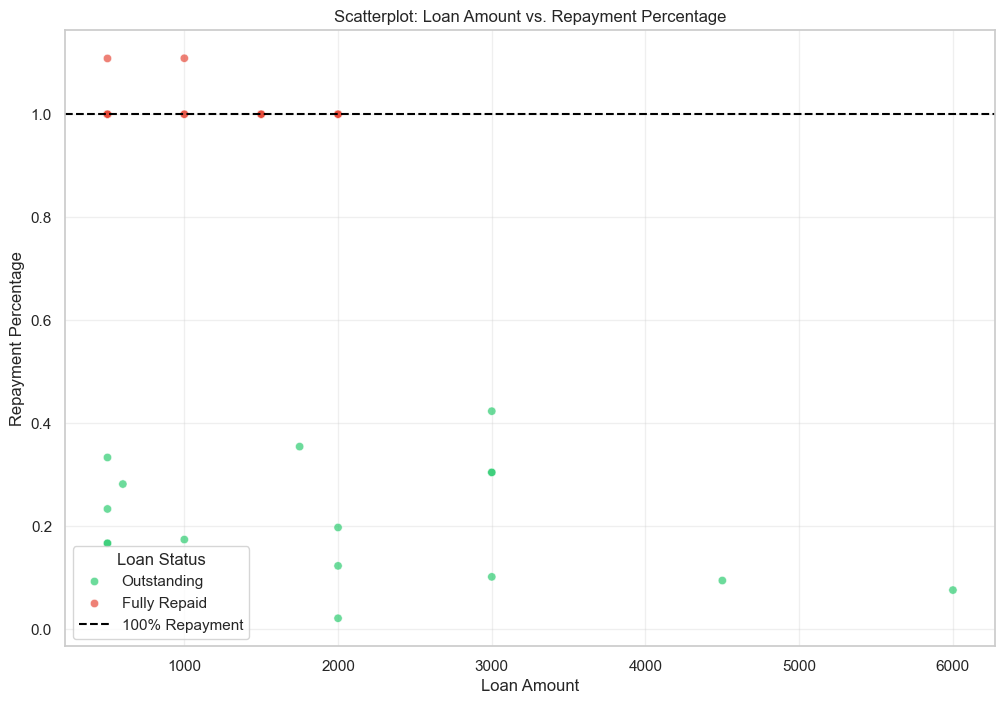

In [ ]:
# Scatterplot: Loan Amount vs. Repayment Percentage
plt.figure(figsize=(12, 8))
sns.scatterplot(x='loan_amount', y='repayment_ratio', hue='loan_status', data=df, palette=['#2ecc71', '#e74c3c'], alpha=0.7)
plt.title('Scatterplot: Loan Amount vs. Repayment Percentage')
plt.xlabel('Loan Amount')
plt.ylabel('Repayment Percentage')
plt.axhline(y=1, color='black', linestyle='--', label='100% Repayment')
plt.legend(title='Loan Status')
plt.grid(alpha=0.3)
plt.show()

C:\Users\ELIZABETH\AppData\Local\Temp\ipykernel_18460\2367786622.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_default_rates = df.set_index('Funded_date').resample('M').apply(


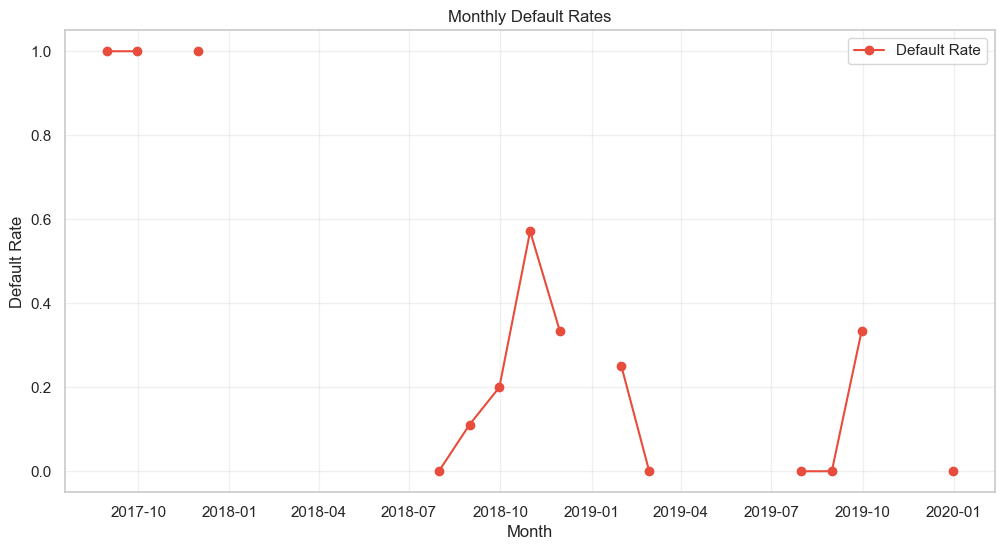

In [3]:
# Plot Monthly Default Rates
monthly_default_rates = df.set_index('Funded_date').resample('M').apply(
    lambda x: (x['loan_status'] == 'Outstanding').mean()
)

plt.figure(figsize=(12, 6))
plt.plot(monthly_default_rates.index, monthly_default_rates.values, marker='o', color='#e74c3c', label='Default Rate')
plt.title('Monthly Default Rates')
plt.xlabel('Month')
plt.ylabel('Default Rate')
plt.grid(alpha=0.3)
plt.legend()
plt.show()